# Microbleed Segmentation


In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd /content/drive/MyDrive/Brain Health In COVID 19/Microbleed_Segmentation

Mounted at /content/drive
/content/drive/MyDrive/Brain Health In COVID 19/Microbleed_Segmentation


## Imports 

In [2]:
!pip install -r Microbleed_Segmentation/requirements.txt

     |████████████████████████████████| 8.3 MB 4.4 MB/s 
     |████████████████████████████████| 492 kB 52.5 MB/s 
     |████████████████████████████████| 428 kB 61.1 MB/s 
     |████████████████████████████████| 392 kB 69.3 MB/s 
     |████████████████████████████████| 56 kB 5.0 MB/s 
     |████████████████████████████████| 112 kB 43.2 MB/s 
     |████████████████████████████████| 52 kB 1.1 MB/s 
     |████████████████████████████████| 77 kB 6.2 MB/s 
     |████████████████████████████████| 56 kB 4.5 MB/s 
  Attempting uninstall: tornado
    Found existing installation: tornado 5.1.1
    Uninstalling tornado-5.1.1:
      Successfully uninstalled tornado-5.1.1
  Attempting uninstall: jsonschema
    Found existing installation: jsonschema 2.6.0
    Uninstalling jsonschema-2.6.0:
      Successfully uninstalled jsonschema-2.6.0
  Attempting uninstall: jupyter-client
    Found existing installation: jupyter-client 5.3.5
    Uninstalling jupyter-client-5.3.5:
      Successfully uninstalled 

In [3]:
!pip install tqdm

In [4]:
import sys
sys.path.append('/content/drive/MyDrive/Brain Health In COVID 19/Microbleed_Segmentation/Microbleed_Segmentation/src')

from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    RandSpatialCrop,
    Spacingd,
    ToTensord,
    NormalizeIntensityd,
    RandAffined,
    ResizeWithPadOrCropd,
    RandWeightedCropd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandZoomd,
    RandSpatialCropd
)
from sampling import RandUniformSamplingCropd
from monai.networks.nets import UNet, BasicUNet
from monai.networks.layers import Norm
from monai.metrics import compute_meandice
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset
from monai.data.utils import pad_list_data_collate
from monai.config import print_config
from monai.apps import download_and_extract
import numpy as np
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
import monai  
import random 
import timeit

from torchsummary import summary

from Transforms import *

from UNet import UNet

import nibabel as nib

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Global Variables


### Path Name Variables


In [5]:
# EPAD resampled SWI images
RESAMPLED_SWI_IMAGES_DIR = '/content/drive/MyDrive/Brain Health In COVID 19/Microbleed_Segmentation/EPAD_WMD/resampled_swi/'

# Directory where brain scan images of public share is located
PUBLICSHARE_IMAGES_DIR =  "/content/drive/MyDrive/Brain Health In COVID 19/Microbleed_Segmentation/EPAD_WMD/SyntheticCMBPaperData/webdav-bm.data.csiro.au/dap_prd_000050304v001/PublicDataShare_2020/sCMB_DefiniteSubject/"

# Directory where predicted labels are stored
PUBLICSHARE_GENERATED_LABELS_DIR = "/content/drive/MyDrive/Brain Health In COVID 19/Microbleed_Segmentation/Microbleed_Segmentation/GeneratedLabels/PredictedLabelsFinal/"

### Other Variables

In [6]:
NIFTY_EXT = ".nii.gz"
LABEL_REPLACE_STRING = "seg_out_"
SEED = 42

## Helper Functions

In [7]:
# Helper functions
class DataDict():
    Image = 'image'
    SwiImage = 'swi_image'
    T2Star = 't2_star'
    Label = 'label'
    ID = 'id'
    VersionId = 'version_id'
    ScanTimeId = 'scan_time_id'
    AffineProperties = 'affine_properties'

def get_swi_subject_id(file_name, is_epad, ext=NIFTY_EXT):
    if is_epad:
        subject_id = int(file_name.split("EPAD")[-1].replace(ext, "").replace("_swi", "").replace("_cmb_seg", ""))
    else:
        subject_id = int(os.path.basename(file_name).replace(LABEL_REPLACE_STRING, "").split('_')[0])
    return subject_id

def get_subject_id_from_image_label(path1, path2):
    is_epad = "EPAD" in os.path.basename(path1)
    
    path1_id = get_swi_subject_id(path1, is_epad)
    path2_id = get_swi_subject_id(path2, is_epad)

    if not path1_id == path2_id:
        raise ValueError("Subject mismatch")

    return path1_id

# From public share get version of image scan
def get_subject_scan_version_from_image_label(path1, path2):
    # E.g. 239_T3_MRI_SWI_BFC_50mm_HM_rsCMB_V2.nii.gz 239_T3_MRI_SWI_BFC_50mm_HM_rsCMB_V2_Label.nii.gz becomes version 2 > return int(2)
    path1 = os.path.basename(path1).replace(LABEL_REPLACE_STRING, "")
    path2 = os.path.basename(path2).replace(LABEL_REPLACE_STRING, "")

    # return as negative 1 to indicate epad data with no versioning
    if "EPAD" in path1:
        return -1

    path1_id = int(path1.split("_")[-1].replace(NIFTY_EXT, "").replace("V", ""))
    path2_id = int(path2.split("_")[-1].replace(NIFTY_EXT, "").replace("V", ""))    
    
    if not path1_id == path2_id:
        raise ValueError("Subject mismatch")

    return path1_id

# From public share get scan time id of image scan
def get_subject_scan_time_version_from_image_label(path1, path2):
    # E.g. 239_T3_MRI_SWI_BFC_50mm_HM_rsCMB_V2.nii.gz 239_T3_MRI_SWI_BFC_50mm_HM_rsCMB_V2_Label.nii.gz becomes scan time id 3 > return int(3)
    path1 = os.path.basename(path1).replace(LABEL_REPLACE_STRING, "")
    path2 = os.path.basename(path2).replace(LABEL_REPLACE_STRING, "")

    # return as negative 1 to indicate epad data with no versioning
    if "EPAD" in path1:
        return -1

    path1_id = int(path1.split("_")[1].replace("T", ""))
    path2_id = int(path2.split("_")[1].replace("T", ""))    
    
    if not path1_id == path2_id:
        raise ValueError("Subject mismatch")

    return path1_id

# Convert torch tensor to numpy array
def numpy_from_tensor(x):
  return x.detach().cpu().numpy()

# Predefined checkpoint dictionary
class CheckpointDict():
    EPOCH = 'epoch'
    MODEL_STATE_DICT = 'model_state_dict'
    OPTIMIZER_STATE_DICT = 'optimizer_state_dict'
    LOSS = 'loss'
    LOSSES = 'losses'
    VALIDATION_LOSSES = 'val_losses'

# Display validation and training loss on a graph
def display_losses(checkpoint, title='Network Losses', x_label='Epoch', y_label='Loss', combine_train_val=True):
    train_losses, val_losses = get_checkpoint_losses(checkpoint)

    val_losses = dict_tensor_to_cpu(val_losses)
    val_tensors = dict_tensor_to_value(val_losses)

    training_losses = sorted(train_losses.items())  # sorted by key, return a list of tuples
    x, y = zip(*training_losses)  # unpack a list of pairs into two tuples
    validation_losses = sorted(val_tensors.items())
    x2, y2 = zip(*validation_losses)  # unpack a list of pairs into two tuples

    if combine_train_val:
        plt.title(title)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.plot(x, y, label="Training")
        plt.plot(x2, y2, label="Validation")
        plt.legend()
        plt.show()
    else:
        fig, axs = plt.subplots(2, 1, constrained_layout=True)
        fig.suptitle(title, fontsize=16)

        axs[0].plot(x, y)
        axs[0].set_title('Training Losses')
        axs[0].set_xlabel(x_label)
        axs[0].set_ylabel(y_label)

        axs[1].plot(x2, y2, color='r')
        axs[1].set_title('Validation Losses')
        axs[1].set_xlabel(x_label)
        axs[1].set_ylabel(y_label)

        plt.show()

# Gets list of training and validation loss
def get_checkpoint_losses(checkpoint):
    losses = checkpoint[CheckpointDict.LOSSES]
    val_losses = checkpoint[CheckpointDict.VALIDATION_LOSSES]
    val_losses = dict_tensor_to_cpu(val_losses)
    val_tensors = dict_tensor_to_value(val_losses)
    return losses, val_losses


def get_checkpoint_model_state_dict(checkpoint):
    return checkpoint[CheckpointDict.MODEL_STATE_DICT]


def dict_tensor_to_cpu(dict_tensors):
    for key in dict_tensors.keys():
        dict_tensors[key] = tensor_to_cpu(dict_tensors[key])

    return dict_tensors


def tensor_to_cpu(x):
    return x.detach().cpu()


def dict_tensor_to_value(dicts):
    if next(iter(dicts)) is not type(torch.tensor):
        return dicts

    for keys in dicts:
        dicts[keys] = dicts[keys].item()

    return dicts

def display_image(image, z=None, title=""):
    plt.title(title)
    if z is None:
        plt.imshow(image[...], cmap='gray')
    else:
        plt.imshow(image[..., z], cmap='gray')


def get_affine_properties(image_path):
    affine_properties = nib.load(image_path).affine
    return affine_properties

## Transforms

In [36]:
PATCH_SIZE = (64, 64, 64)

#Transforms
train_transforms = Compose(
    [
        LoadImaged(keys=[DataDict.Image, DataDict.Label]),
        AddChanneld(keys=[DataDict.Image, DataDict.Label]),
        # ConvertToMultiChannelBasedOnLabelsClassesd(keys=[DataDict.Label]),
        Spacingd(keys=[DataDict.Image, DataDict.Label], pixdim=(
            1.0, 1.0, 1.0), mode=("bilinear", "nearest")),
        Orientationd(keys=[DataDict.Image, DataDict.Label], axcodes="RAS"),
        ResizeWithPadOrCropd(keys=[DataDict.Image, DataDict.Label], spatial_size=(200, 200, 200)),
        RandCropByPosNegLabeld(
            keys=[DataDict.Image, DataDict.Label],
            label_key=DataDict.Label,
            spatial_size=(100, 100, 100), 
            pos=1,
            neg=1,
            num_samples=1,
            image_key=DataDict.Image,
            image_threshold=0,
        ),    
        RandSpatialCropd(keys=[DataDict.Image, DataDict.Label], roi_size=PATCH_SIZE, random_center=True, random_size=False),
        NormalizeIntensityd(keys=[DataDict.Image]),
        RandScaleIntensityd(keys=[DataDict.Image], factors=0.1, prob=0.5),
        RandShiftIntensityd(keys=[DataDict.Image], offsets=0.1, prob=0.5),
        RandZoomd(keys=[ DataDict.Image, DataDict.Label], prob=1.0, min_zoom=0.9, max_zoom=1.1),
        ConvertToMultiChannelBasedOnLabelsClassesd(keys=[DataDict.Label]),
        ToTensord(keys=[DataDict.Image, DataDict.Label]),
    ]
)


validation_transforms = Compose(
    [
        LoadImaged(keys=[DataDict.Image, DataDict.Label]),
        AddChanneld(keys=[DataDict.Image, DataDict.Label]),
        # ConvertToMultiChannelBasedOnLabelsClassesd(keys=[DataDict.Label]),
        Spacingd(keys=[DataDict.Image, DataDict.Label], pixdim=(
            1.0, 1.0, 1.0), mode=("bilinear", "nearest")),
        Orientationd(keys=[DataDict.Image, DataDict.Label], axcodes="RAS"),
        ResizeWithPadOrCropd(keys=[DataDict.Image, DataDict.Label], spatial_size=(200, 200, 200)),
        NormalizeIntensityd(keys=[DataDict.Image]),
        ConvertToMultiChannelBasedOnLabelsClassesd(keys=[DataDict.Label]),
        ToTensord(keys=[DataDict.Image, DataDict.Label]),
    ]
)


test_transforms = Compose(
    [
        LoadImaged(keys=[DataDict.Image, DataDict.Label]),
        AddChanneld(keys=[DataDict.Image, DataDict.Label]),
        # ConvertToMultiChannelBasedOnLabelsClassesd(keys=[DataDict.Label]),
        Spacingd(keys=[DataDict.Image, DataDict.Label], pixdim=(
            1.0, 1.0, 1.0), mode=("bilinear", "nearest")),
        Orientationd(keys=[DataDict.Image, DataDict.Label], axcodes="RAS"),
        ResizeWithPadOrCropd(keys=[DataDict.Image, DataDict.Label], spatial_size=(200, 200, 200)),
        NormalizeIntensityd(keys=[DataDict.Image]),
        ConvertToMultiChannelBasedOnLabelsClassesd(keys=[DataDict.Label]),
        ToTensord(keys=[DataDict.Image, DataDict.Label]),
    ]
)

## Data Setup

### Resampled SWI data

In [37]:
data_dir = RESAMPLED_SWI_IMAGES_DIR 
images_dir = os.path.join(data_dir, 'images')
labels_dir = os.path.join(data_dir, 'labels')

train_images = sorted(glob.glob(os.path.join(images_dir, f"*_swi{NIFTY_EXT}")))
train_labels = sorted(glob.glob(os.path.join(labels_dir, f"*_cmb_seg{NIFTY_EXT}")))

### Stroke Public Share Data Custom Annotated Data

In [38]:
include_publicshare_data = True

In [39]:
# INSERT PUBLIC SHARE TRAINED LABELS DATA HERE
# Get image path list
train_images_publicshare = glob.glob(os.path.join(PUBLICSHARE_IMAGES_DIR, f"*{NIFTY_EXT}"))

# Get label path list - located in a folding format
train_labels_publicshare = []
for root, dirs, files in os.walk(PUBLICSHARE_GENERATED_LABELS_DIR):
    for file in files:
        if(file.endswith(NIFTY_EXT)):
            filename_path = os.path.join(root, file)
            train_labels_publicshare.append(filename_path)

for train_label_publicshare in train_labels_publicshare:
    target_basename_image_name = os.path.basename(train_label_publicshare).replace(LABEL_REPLACE_STRING, "")
    
    target_image_path = next(x for x in train_images_publicshare if target_basename_image_name == os.path.basename(x))

    # print(os.path.basename(train_label_publicshare), os.path.basename(target_image_path))
    if include_publicshare_data: 
        train_images.append(target_image_path)
        train_labels.append(train_label_publicshare)

# Check images and labels match
for i in range(len(train_images)):
    is_epad = "EPAD" in os.path.basename(train_images[i])
    is_matching_image_and_labels = False

    if is_epad:
        is_matching_image_and_labels = os.path.basename(train_images[i]).replace(f"_swi{NIFTY_EXT}", "").replace(f"_cmb_seg{NIFTY_EXT}", "") == os.path.basename(train_labels[i]).replace(f"_swi{NIFTY_EXT}", "").replace(f"_cmb_seg{NIFTY_EXT}", "")
    else:
        is_matching_image_and_labels = os.path.basename(train_images[i]).replace(LABEL_REPLACE_STRING, "") == os.path.basename(train_labels[i]).replace(LABEL_REPLACE_STRING, "")

    # Check each pair are matching images and labels
    if not is_matching_image_and_labels: 
        raise ValueError(f"Non-matching pairs: {os.path.basename(train_images[i]), os.path.basename(train_labels[i])}")

# Double check each pairs are matching samples 
random1 = random.randint(0, len(train_images)-1)
random2 = random.randint(0, len(train_images)-1)

print(os.path.basename(train_images[0]), os.path.basename(train_labels[0]))
print(os.path.basename(train_images[random1]), os.path.basename(train_labels[random1]))
print(os.path.basename(train_images[random2]), os.path.basename(train_labels[random2]))

020EPAD23511_swi.nii.gz 020EPAD23511_cmb_seg.nii.gz
275_T1_MRI_SWI_BFC_50mm_HM_rsCMB_V1.nii.gz seg_out_275_T1_MRI_SWI_BFC_50mm_HM_rsCMB_V1.nii.gz
239_T2_MRI_SWI_BFC_50mm_HM_rsCMB_V2.nii.gz seg_out_239_T2_MRI_SWI_BFC_50mm_HM_rsCMB_V2.nii.gz


### Data Dict and Dataset Creation

In [40]:
# TODO
data_dicts = [
    {DataDict.Image: image_name, DataDict.Label: label_name, 
     DataDict.ID: get_subject_id_from_image_label(image_name, label_name), 
     DataDict.VersionId: get_subject_scan_version_from_image_label(image_name, label_name),
     DataDict.ScanTimeId: get_subject_scan_time_version_from_image_label(image_name, label_name),
     DataDict.AffineProperties: get_affine_properties(image_name)}
    for image_name, label_name in zip(train_images, train_labels)
]

len(data_dicts)

610

In [41]:
data_dicts[200]

{'affine_properties': array([[-9.35328960e-01,  0.00000000e+00, -1.19026661e-01,
          8.57998581e+01],
        [ 0.00000000e+00, -9.37500000e-01,  0.00000000e+00,
          1.39370453e+02],
        [-6.37643337e-02,  0.00000000e+00,  1.74594498e+00,
         -4.88258171e+01],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]]),
 'id': 239,
 'image': '/content/drive/MyDrive/Brain Health In COVID 19/Microbleed_Segmentation/EPAD_WMD/SyntheticCMBPaperData/webdav-bm.data.csiro.au/dap_prd_000050304v001/PublicDataShare_2020/sCMB_DefiniteSubject/239_T3_MRI_SWI_BFC_50mm_HM_rsCMB_V2.nii.gz',
 'label': '/content/drive/MyDrive/Brain Health In COVID 19/Microbleed_Segmentation/Microbleed_Segmentation/GeneratedLabels/PredictedLabelsFinal/239_T3_V2/seg_out_239_T3_MRI_SWI_BFC_50mm_HM_rsCMB_V2.nii.gz',
 'scan_time_id': 3,
 'version_id': 2}

In [42]:
train_split = int(0.6*len(data_dicts))
val_split = int(0.8*len(data_dicts))

# Shuffle data dict so splits dont all contain EPAD only data or group categories specific data per split
random.Random(SEED).shuffle(data_dicts)

# Split 
train_files, val_files, test_files = data_dicts[:train_split], data_dicts[train_split:val_split], data_dicts[val_split:]

# Initialise datasets 
train_dataset = Dataset(data=train_files, transform=train_transforms)
validation_dataset = Dataset(data=val_files, transform=validation_transforms)
test_dataset = Dataset(data=test_files, transform=test_transforms)

# Initialise Dataset
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0, collate_fn=pad_list_data_collate)
val_loader = DataLoader(validation_dataset, batch_size=16, num_workers=0, collate_fn=pad_list_data_collate)
test_loader = DataLoader(test_dataset, batch_size=16, num_workers=0, collate_fn=pad_list_data_collate)

### Test Dataload images

In [43]:
loaded_item = next(iter(train_loader))

In [44]:
view_z_slice = int(PATCH_SIZE[0]/2)
batch_number = 5

loaded_item[DataDict.ID][batch_number]

tensor(255)

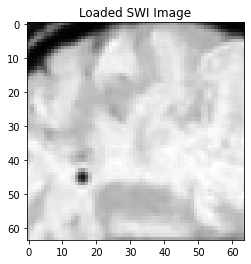

In [45]:
display_image(loaded_item[DataDict.Image][batch_number, 0, ...], view_z_slice, 'Loaded SWI Image')

In [46]:
print(loaded_item[DataDict.Label].shape)

torch.Size([16, 2, 64, 64, 64])


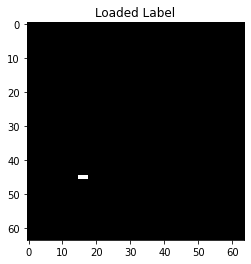

In [47]:
display_image(loaded_item[DataDict.Label][batch_number, 1, ...], view_z_slice, 'Loaded Label')

## Network and Training Parameter Setup

In [48]:
# UNet Setup 1
model = UNet(
    dimensions=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    dropout=0.2
).to(DEVICE)

loss_function = DiceLoss(include_background=False)

optimizer = torch.optim.Adam(
    model.parameters(), 1e-3, weight_decay=1e-5, amsgrad=True,
)

## Training Function

In [49]:
def train_network(training_loader, val_loader, network,
                  loss_fun, optimizer, EPOCHS=600,
                  pre_load_training=False, checkpoint_name='', device=DEVICE, save_new_every=None, validation_every=2):

    network.cuda(device)

    optimizer = optimizer
    loss_fun = loss_fun

    epoch_checkpoint = 0

    losses = {}
    val_losses = {}

    save_part = 0

    if pre_load_training:
        checkpoint = torch.load(TRAINED_NETWORK_DIR + f'{checkpoint_name}.pt')
        epoch_checkpoint = checkpoint[CheckpointDict.EPOCH] + 1
        network.load_state_dict(checkpoint[CheckpointDict.MODEL_STATE_DICT])
        optimizer.load_state_dict(checkpoint[CheckpointDict.OPTIMIZER_STATE_DICT])
        loss = checkpoint[CheckpointDict.LOSS]
        losses = checkpoint[CheckpointDict.LOSSES]
        val_losses = checkpoint[CheckpointDict.VALIDATION_LOSSES]

    # Train the network
    for epoch in range(epoch_checkpoint, EPOCHS):
        tic = timeit.default_timer()

        # Save new checkpoint name every x epochs
        if save_new_every is not None:
            save_part = int(epoch / save_new_every)

            # if epoch % save_new_every == 0 and epoch != 0:
            #     if save_part != 0:
            #         checkpoint_name = f"{checkpoint_name}_part{save_part}"

        network.train(True)

        print(f'losses: {losses}')
        print(f'val losses {val_losses}')

        train_step = 1
        batch_loss = []

        for batch_data in training_loader:
            print(f'Epoch {epoch}\tTraining Step: {train_step}/{len(training_loader)}')

            torch.cuda.empty_cache()  # Clear any unused variables
            inputs = batch_data[DataDict.Image].to(device)
            labels = batch_data[DataDict.Label]  # Only pass to CUDA when required - preserve memory

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Feed input data into the network to train
            outputs = network(inputs)

            # Input no longer in use for current iteration - clear from CUDA memory
            inputs = inputs.cpu()
            torch.cuda.empty_cache()

            # labels to CUDA
            labels = batch_data[DataDict.Label].to(device)
            torch.cuda.empty_cache()

            # Calculate DICE CE loss, permute tensors to correct dimensions
            loss = loss_fun(outputs, labels)
            # print(f"Train step: {train_step}\tEpoch: {epoch}\tLoss:{loss}")

            # List of losses for current batch
            batch_loss.append(loss.detach().cpu().numpy())

            # Clear CUDA memory
            labels = labels.cpu()
            torch.cuda.empty_cache()

            # Backward pass
            loss.backward()

            # Optimize
            optimizer.step()

            train_step += 1

        # Get average loss for current batch
        losses[epoch] = np.mean(batch_loss)
        print(f'train losses {batch_loss} \nmean loss {losses[epoch]}')

        if epoch % validation_every == 0:
            # Set network to eval mode
            network.train(False)
            # Disiable gradient calculation and optimise memory
            with torch.no_grad():
                # Initialise validation loss
                val_loss_total = 0
                val_iter_count = 0

                for i, batch_data in enumerate(val_loader):
                    # Get inputs and labels from validation set
                    val_inputs = batch_data[DataDict.Image].to(device)
                    val_labels = batch_data[DataDict.Label]

                    # Validation inference
                    roi_size = PATCH_SIZE
                    sw_batch_size = 2
                    val_outputs = sliding_window_inference(
                        val_inputs, roi_size, sw_batch_size, network)

                    # # Memory optimization
                    val_inputs = val_inputs.cpu()
                    torch.cuda.empty_cache()
                    val_labels = batch_data[DataDict.Label].to(device)

                    # val_outputs = post_pred(val_outputs)
                    # val_labels = post_label(val_labels)

                    # Accumulate DICE CE loss validation error
                    val_loss = loss_fun(val_outputs, val_labels)
                    val_loss_total += val_loss

                    val_iter_count += 1
                    # print(f'Val loss iter {i}: {val_loss}')

                # Get average validation DICE CE loss
                val_losses[epoch] = val_loss_total / val_iter_count

                # Print errors
                print(
                    "==== VALIDATION LOSS:: Epoch: " + str(epoch) +
                    " | DICE loss: " + str(numpy_from_tensor((val_loss_total) / val_iter_count)) +
                    " | Total Loss: " + str(numpy_from_tensor((
                                                                  val_loss_total) / val_iter_count)) + " =====")  # This is redundant code but will keep here incase we add more losses

        toc = timeit.default_timer()
        print(f"Epoch {epoch} duration: {int((toc-tic)/60)}minutes")

        if save_part != 0:
            save_name = f"{checkpoint_name}_part{save_part}"
        else:
            save_name = checkpoint_name

        # Save training checkpoint
        torch.save({
            CheckpointDict.EPOCH: epoch,
            CheckpointDict.MODEL_STATE_DICT: network.state_dict(),
            CheckpointDict.OPTIMIZER_STATE_DICT: optimizer.state_dict(),
            CheckpointDict.LOSS: loss,
            CheckpointDict.LOSSES: losses,
            CheckpointDict.VALIDATION_LOSSES: val_losses
        }, TRAINED_NETWORK_DIR + f'{save_name}.pt')

        # Confirm current epoch trained params are saved
        print(f'Saved for epoch {epoch}\n Under name: {save_name}\n')

    return network

In [50]:
summary(model, (1, PATCH_SIZE[0], PATCH_SIZE[1], PATCH_SIZE[2]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 16, 32, 32, 32]             448
            Conv3d-2       [-1, 16, 32, 32, 32]             448
    InstanceNorm3d-3       [-1, 16, 32, 32, 32]               0
           Dropout-4       [-1, 16, 32, 32, 32]               0
             PReLU-5       [-1, 16, 32, 32, 32]               1
            Conv3d-6       [-1, 16, 32, 32, 32]           6,928
    InstanceNorm3d-7       [-1, 16, 32, 32, 32]               0
           Dropout-8       [-1, 16, 32, 32, 32]               0
             PReLU-9       [-1, 16, 32, 32, 32]               1
     ResidualUnit-10       [-1, 16, 32, 32, 32]               0
           Conv3d-11       [-1, 32, 16, 16, 16]          13,856
           Conv3d-12       [-1, 32, 16, 16, 16]          13,856
   InstanceNorm3d-13       [-1, 32, 16, 16, 16]               0
          Dropout-14       [-1, 32, 16,

## Checkpoint Name

In [51]:
# Best Trained with original data 
# checkpoint_name = "microbleed_segmentation_checkpoint14"

# New training with Stroke data
# checkpoint_name = "microbleed_segmentation_checkpoint15"
# checkpoint_name = "microbleed_segmentation_checkpoint15_part1_part2_part3"

# New training data with all stroke data
# checkpoint_name = "microbleed_segmentation_checkpoint16"

# # New training data with all stroke data from epoch 300 onwards
# checkpoint_name = "microbleed_segmentation_checkpoint17"


# # New training data with all stroke data with 50% sample rate
# checkpoint_name = "microbleed_segmentation_checkpoint18"

# New training data with all stroke data with 50% sample rate and correct coordinate shifts batch 32
# checkpoint_name = "microbleed_segmentation_checkpoint19"

# New training data with all stroke data with 50% sample rate and correct coordinate shifts batch from 32 to 16
#{'FP mean': 15.836065573770492, 'TP %': 79.20656634746922, 'FN %': 20.79343365253078, 'precision': 0.37475728155339805, 'recall': 0.7920656634746921}
checkpoint_name = "microbleed_segmentation_checkpoint20"

# New training data with all stroke data with 50% sample rate and correct coordinate shifts batch from 32 to 16
# Checkpoint 20 but continued training from epoch 350
checkpoint_name = "microbleed_segmentation_checkpoint21"

## Training

In [ ]:
TRAINED_NETWORK_DIR = '/content/drive/MyDrive/Brain Health In COVID 19/Microbleed_Segmentation/Microbleed_Segmentation/TrainedNetworks/'
train_net = True

if train_net:
    net = train_network(
        training_loader=train_loader, val_loader=val_loader,
                      network=model, loss_fun=loss_function,
                          optimizer=optimizer, EPOCHS=1501, pre_load_training=True, checkpoint_name=f'{checkpoint_name}', save_new_every=500, validation_every=5)


losses: {0: 0.99991304, 1: 0.99988407, 2: 0.99985594, 3: 0.9998308, 4: 0.99975586, 5: 0.999732, 6: 0.99971694, 7: 0.9994393, 8: 0.99930304, 9: 0.99904084, 10: 0.99856573, 11: 0.9982628, 12: 0.9958534, 13: 0.9893169, 14: 0.9711291, 15: 0.944093, 16: 0.90163404, 17: 0.8870949, 18: 0.8551306, 19: 0.86128616, 20: 0.83524513, 21: 0.82598954, 22: 0.83922076, 23: 0.83048844, 24: 0.8059135, 25: 0.8072936, 26: 0.8113597, 27: 0.8181522, 28: 0.8153577, 29: 0.7765873, 30: 0.78539747, 31: 0.7872905, 32: 0.80532223, 33: 0.79740494, 34: 0.80860764, 35: 0.7989647, 36: 0.78510404, 37: 0.7944908, 38: 0.7909508, 39: 0.7804406, 40: 0.7895829, 41: 0.8051386, 42: 0.7990258, 43: 0.8000528, 44: 0.76800466, 45: 0.8080184, 46: 0.7561546, 47: 0.7743439, 48: 0.81478935, 49: 0.7911535, 50: 0.79600054, 51: 0.79681903, 52: 0.80570245, 53: 0.7929447, 54: 0.80968267, 55: 0.7909578, 56: 0.78792334, 57: 0.791879, 58: 0.7724819, 59: 0.8027269, 60: 0.7857943, 61: 0.78814024, 62: 0.7881194, 63: 0.7849365, 64: 0.7944986, 65

## Evaluating Network Performance

In [53]:
checkpoint = torch.load(f'{TRAINED_NETWORK_DIR}/{checkpoint_name}.pt')

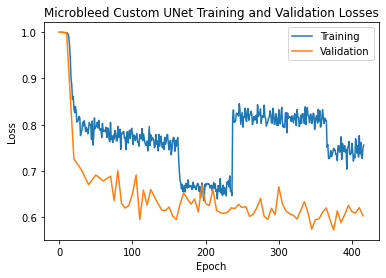

In [54]:
display_losses(checkpoint, title='Microbleed Custom UNet Training and Validation Losses', combine_train_val=True)

In [55]:
print(f"Training Loss: {round(float(checkpoint[CheckpointDict.LOSSES][list(checkpoint[CheckpointDict.LOSSES])[-1]]), 4)}")
print(f"Validation Loss: {round(float(checkpoint[CheckpointDict.VALIDATION_LOSSES][list(checkpoint[CheckpointDict.VALIDATION_LOSSES])[-1]]), 4)}")

Training Loss: 0.7561
Validation Loss: 0.6035


!!!INFORMATION

microbleed_segmentation_checkpoint6 best so far at > 800 epochs with augmentations

microbleed_segmentation_checkpoint0-7 : 96*96*96 patch size


Inference on one validation

In [56]:
def infer_validation_data(model, data):
    inference_input = data[DataDict.Image].unsqueeze(0).to(DEVICE)
    inference_label = data[DataDict.Label]

    # Validation inference
    roi_size = PATCH_SIZE
    sw_batch_size = 2
    inference_output = sliding_window_inference(
        inference_input, roi_size, sw_batch_size, inference_model)
    
    inference_output = torch.where(inference_output > 0.5, 1, 0)

    return inference_input, inference_output, inference_label

In [57]:
print(len(test_dataset))

122


In [58]:
inference_model = model
inference_model.load_state_dict(checkpoint[CheckpointDict.MODEL_STATE_DICT])

inference_results = []
infer_dataset = True

LABELS_OUTPUT_DIR = "/content/drive/MyDrive/Brain Health In COVID 19/Microbleed_Segmentation/Microbleed_Segmentation/Predictions/Labels_Patch64/"
PREDICTIONS_OUTPUT_DIR = "/content/drive/MyDrive/Brain Health In COVID 19/Microbleed_Segmentation/Microbleed_Segmentation/Predictions/Predictions_Patch64/"

if not os.path.exists(LABELS_OUTPUT_DIR):
    os.mkdir(LABELS_OUTPUT_DIR)

if not os.path.exists(PREDICTIONS_OUTPUT_DIR):
    os.mkdir(PREDICTIONS_OUTPUT_DIR)

if infer_dataset:
    # Check for 10 results
    # for i in range(10):
    for i in range(len(test_dataset)):
        testing_single_set = test_dataset[i]
        id = testing_single_set[DataDict.ID]
        version_id = testing_single_set[DataDict.VersionId]
        scan_time_id = testing_single_set[DataDict.ScanTimeId]

        print(f"{i+1}/{len(test_dataset)}\tSubjectId: {id}\tVersion_ID:{version_id}\tScanTime_Id:{scan_time_id}")
        inference_input, inference_output, inference_label = infer_validation_data(inference_model, testing_single_set)
        
        affine_properties = testing_single_set[DataDict.AffineProperties]

        # print(inference_output.shape)
        # print(inference_label.shape)
        nb_output_to_save = nib.Nifti1Image(np.array(tensor_to_cpu(inference_output[0, 1])), affine_properties)
        nb_label_to_save = nib.Nifti1Image(np.array(tensor_to_cpu(inference_label[1])), affine_properties)

        label_dir = os.path.join(LABELS_OUTPUT_DIR, f"{str(id)}_V{version_id}_T{scan_time_id}")
        pred_dir = os.path.join(PREDICTIONS_OUTPUT_DIR, f"{str(id)}_V{version_id}_T{scan_time_id}")

        if not os.path.exists(label_dir):
            os.mkdir(label_dir)

        if not os.path.exists(pred_dir):
            os.mkdir(pred_dir)

        nib.save(nb_output_to_save, f"{pred_dir}/seg_out_{id}_V{version_id}_T{scan_time_id}{NIFTY_EXT}")
        nib.save(nb_label_to_save, f"{label_dir}/label_{id}_V{version_id}_T{scan_time_id}{NIFTY_EXT}")

        # nib.save(nb_output_to_save, f"{pred_dir}/{id}.nii.gz")
        # nib.save(nb_label_to_save, f"{label_dir}/{id}.nii.gz")


1/122	SubjectId: 122	Version_ID:10	ScanTime_Id:2
2/122	SubjectId: 273	Version_ID:3	ScanTime_Id:2
3/122	SubjectId: 301	Version_ID:3	ScanTime_Id:2
4/122	SubjectId: 23894	Version_ID:-1	ScanTime_Id:-1
5/122	SubjectId: 294	Version_ID:8	ScanTime_Id:2
6/122	SubjectId: 301	Version_ID:9	ScanTime_Id:2
7/122	SubjectId: 256	Version_ID:5	ScanTime_Id:0
8/122	SubjectId: 222	Version_ID:10	ScanTime_Id:1
9/122	SubjectId: 311	Version_ID:1	ScanTime_Id:1
10/122	SubjectId: 249	Version_ID:1	ScanTime_Id:0
11/122	SubjectId: 301	Version_ID:1	ScanTime_Id:2
12/122	SubjectId: 239	Version_ID:7	ScanTime_Id:2
13/122	SubjectId: 239	Version_ID:9	ScanTime_Id:2
14/122	SubjectId: 305	Version_ID:3	ScanTime_Id:1
15/122	SubjectId: 257	Version_ID:8	ScanTime_Id:1
16/122	SubjectId: 305	Version_ID:8	ScanTime_Id:0
17/122	SubjectId: 311	Version_ID:2	ScanTime_Id:2
18/122	SubjectId: 305	Version_ID:4	ScanTime_Id:0
19/122	SubjectId: 308	Version_ID:7	ScanTime_Id:1
20/122	SubjectId: 260	Version_ID:4	ScanTime_Id:1
21/122	SubjectId: 218	V

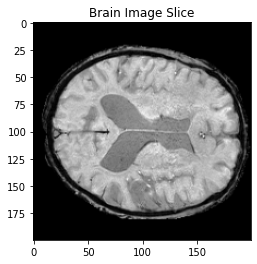

In [59]:
# print(f"Subject_id: {testing_single_set[DataDict.ID]}")

z = 100


display_image(tensor_to_cpu(inference_input[0, 0, ...]), z, 'Brain Image Slice')

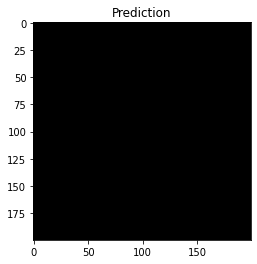

In [60]:
display_image(tensor_to_cpu(inference_output[0, 1, ...]), z, 'Prediction')

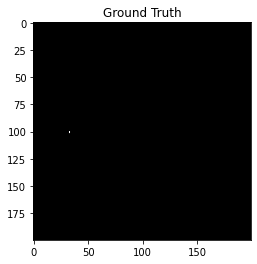

In [61]:
display_image(tensor_to_cpu(inference_label[1, ...]), z, 'Ground Truth')

In [62]:
import EvalCMBSeg as evalcmb

In [63]:
evalcmb.labelPath = LABELS_OUTPUT_DIR
evalcmb.segoutPath = PREDICTIONS_OUTPUT_DIR

evalcmb.labelPrefix = "label_"
evalcmb.imagePrefix = "seg_out_"

results =  evalcmb.get_metrics(using_folds=True)        

print(results)

Image 122_V10_T2.nii.gz statistics:
True positives: 12 
False positives: 19
False negatives:  3
Predicted number of microbleeds: 31 
Actual number of microbleeds: 15
Image 273_V3_T2.nii.gz statistics:
True positives: 10 
False positives: 12
False negatives:  4
Predicted number of microbleeds: 22 
Actual number of microbleeds: 14
Image 301_V3_T2.nii.gz statistics:
True positives: 9 
False positives: 11
False negatives:  1
Predicted number of microbleeds: 20 
Actual number of microbleeds: 10
Image 23894_V-1_T-1.nii.gz statistics:
True positives: 4 
False positives: 48
False negatives:  0
Predicted number of microbleeds: 52 
Actual number of microbleeds: 4
Image 294_V8_T2.nii.gz statistics:
True positives: 9 
False positives: 7
False negatives:  2
Predicted number of microbleeds: 16 
Actual number of microbleeds: 11
Image 301_V9_T2.nii.gz statistics:
True positives: 4 
False positives: 15
False negatives:  8
Predicted number of microbleeds: 19 
Actual number of microbleeds: 12
Image 256_V

Around epoch 237
Training Loss: 0.6789
Validation Loss: 0.6109
{'FP mean': 19.959016393442624, 'TP %': 75.23939808481532, 'FN %': 24.76060191518468, 'precision': 0.31117397454031115, 'recall': 0.7523939808481532}

{'FP mean': 17.598360655737704, 'TP %': 79.20656634746922, 'FN %': 20.79343365253078, 'precision': 0.35037821482602116, 'recall': 0.7920656634746921}

{'FP mean': 15.836065573770492, 'TP %': 79.20656634746922, 'FN %': 20.79343365253078, 'precision': 0.37475728155339805, 'recall': 0.7920656634746921}

{'FP mean': 22.131147540983605, 'TP %': 80.23255813953489, 'FN %': 19.767441860465116, 'precision': 0.30286599535243997, 'recall': 0.8023255813953488}